
# 5.3. Import TensorFlow model into MATLAB

To illustrate the [TensorFlow & ONNX import/export capabilities](https://blogs.mathworks.com/deep-learning/2022/03/18/importing-models-from-tensorflow-pytorch-and-onnx/), we will take a workflow around an autonomous driving use case.


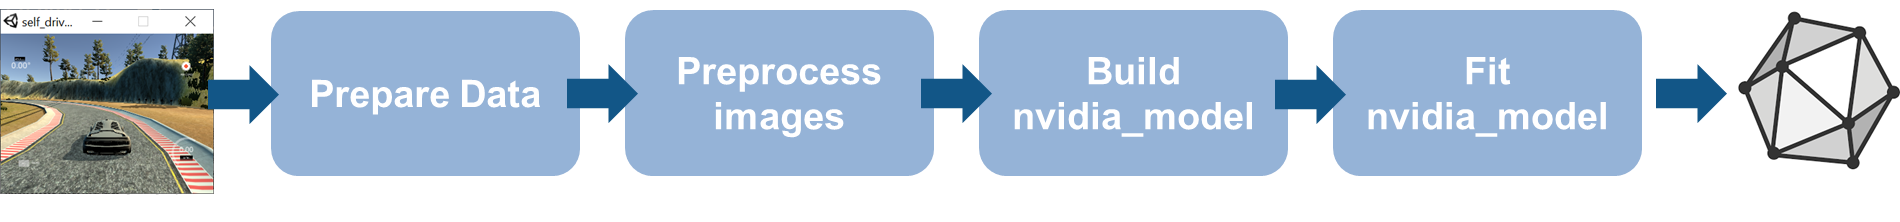


The data is generated by a simple [open-source driving simulator](https://github.com/udacity/self-driving-car-sim) from Udacity.


And the model comes from a real-life experiment from NVIDIA about [End-to-end learning for self-driving cars](https://arxiv.org/pdf/1604.07316.pdf).



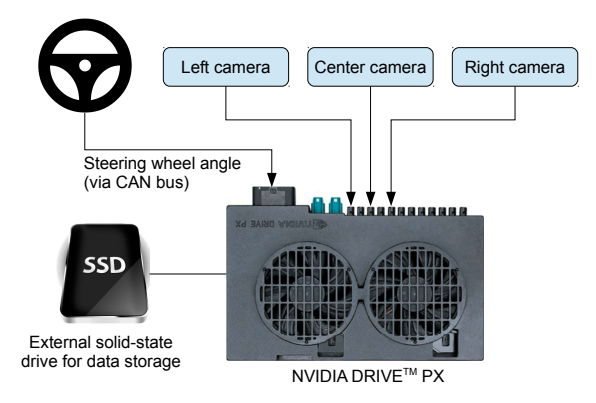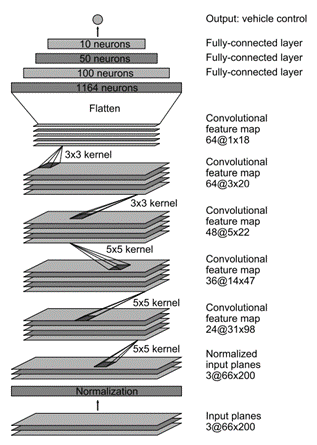


The inputs of the neural network are images from the camera and the output to predict in the steering angle (between -1 and 1).


We will simplify the problem with only 5 classes(from left to right).


*(optional)* Set up the parallel pool to use 4 workers for training on CPU


In [1]:
p = gcp('nocreate'); % If no pool, do not create new one.
if isempty(p)
   parpool()
else
    poolsize = p.NumWorkers
end


Import csv file created by the Udacity simulator with the images locations and the steering ground truth.


In [2]:
filename = "driving_log.csv";
drivinglog = import_driving_log( filename );
drivinglog = drivinglog(2:end,:)


**Prepare data**


Analyse the range of values for the steering angle to find the optimal class values.


In [3]:
figure;
histogram(drivinglog.steering);
title("Original steering angle distribution");


Use discretize to group the steering angles into discrete bins.


In [4]:
steeringLimits = [-1 -0.5 -0.05 0 0.05 0.5 1];
steeringClasses = discretize(drivinglog.steering, steeringLimits, 'categorical');
classNames = categories(steeringClasses);


Merge the two bins that represent the angle close to 0 degrees.


In [5]:
steeringClasses = mergecats(steeringClasses,["[-0.05, 0)","[0, 0.05)"], "0.0");
histogramClasses = histogram(steeringClasses);
title("Angle distribution discretized (5 categories)");

<a name="H_7F6F4EE4"></a>

**Create image datastore and balance data (undersampling)**


The previous histogram shows that the dataset is highly unbalanced. Use countEachLabel to check how many instances there are of each class.


In [6]:
imds = imageDatastore("sim_data/"+drivinglog.center,"Labels", steeringClasses);
countEachLabel(imds)


Define how many samples of the unbalanced class should be kept and randomly select these samples.


In [7]:
maxSamples = 800;
countLabel = countEachLabel(imds);
[~, unbalancedLabelIdx] = max(countLabel.Count);
unbalanced = imds.Labels == countLabel.Label(unbalancedLabelIdx);
idx = find(unbalanced);
randomIdx = randperm(numel(idx));
downsampled = idx(randomIdx(1:maxSamples));
retained = [find(~unbalanced) ; downsampled];
imds = subset(imds, retained');
histogram(imds.Labels)

<a name="H_E0C691CC"></a>

**Separate the dataset into training, validation and testing**


Extract 90% of the data for training and the remaining for testing and validation.


In [8]:
[imdsTrain, imdsValid,imdsTest] = splitEachLabel(imds, 0.9, 0.05, 0.05);


**Preprocess the images** by resizing it and converting it to the YCbCr color space.


In [9]:
trainData = transform(imdsTrain, @imagePreprocess, "IncludeInfo", true);
testData = transform(imdsTest, @imagePreprocess, "IncludeInfo", true);
valData = transform(imdsValid, @imagePreprocess, "IncludeInfo", true);
imds_origI = imdsTrain.read;
imds_newI = trainData.read{1};
subplot(211), imshow(imds_origI), title("Original image from imds")
subplot(212), imshow(imds_newI), title("Preprocessed image from imds")


**Modify the model:**


Load the network from keras model and display with [Deep Network Designer](https://www.mathworks.com/help/deeplearning/gs/get-started-with-deep-network-designer.html).


It is recommended to save and import the model in the SavedModel format instead of the [HDF5 format](http://www.tensorflow.org/tutorials/keras/save_and_load#save_the_entire_model) (you might get a warning).


In [10]:
layers = importKerasLayers("tf_model.h5")

In [11]:
deepNetworkDesigner(layers)


Remove the last layer used for regression and add the layers for a classification with 5 classes (then export net as **layers_1**)


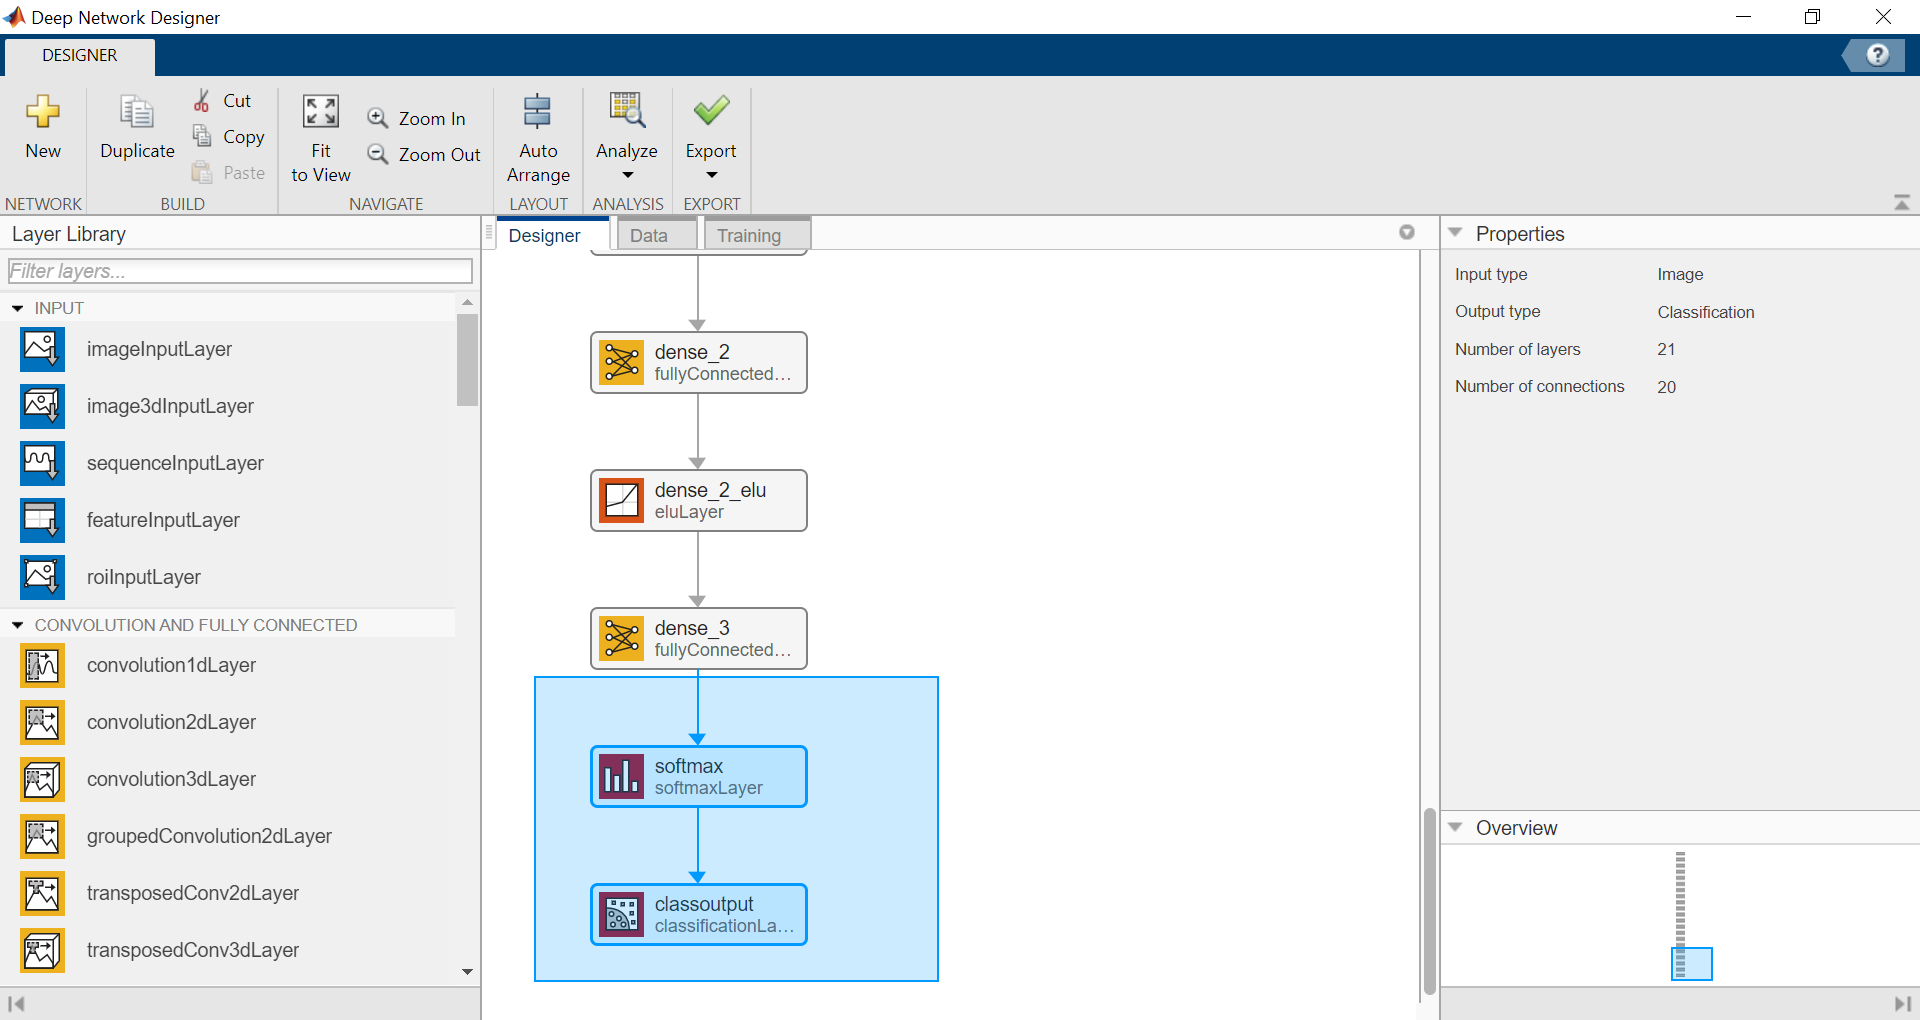


*(programmatic alternative)* Remove layers used for regression and add the layers for a classification with 5 classes


In [12]:
netGraph = layerGraph(layers);
clf; plot(netGraph)

In [13]:
classificationLayers = [fullyConnectedLayer(5,"Name","dense_3"), ...
                        softmaxLayer("Name","softmax"), ...
                        classificationLayer("Name","classoutput")];
netGraph = removeLayers(netGraph, {'dense_3', 'RegressionLayer_dense_3'});
netGraph = addLayers(netGraph,classificationLayers);
layers_1 = netGraph.Layers


**Train the model:** (I am using my CPU here, but I recommend to speed it up on a GPU)


In [14]:
initialLearnRate = 0.001;
maxEpochs = 30;
miniBatchSize = 100;
options = trainingOptions("adam", ...
    "MaxEpochs",maxEpochs, ...
    "InitialLearnRate",initialLearnRate, ...
    "Plots","training-progress",  ...
    "ValidationData",valData, ...
    "ValidationFrequency",10, ...
    "LearnRateSchedule","piecewise", ...
    "LearnRateDropPeriod",10, ...
    "LearnRateDropFactor",0.5, ...
    "ExecutionEnvironment","parallel",...
    "Shuffle","every-epoch");
net = trainNetwork(trainData, layers_1, options);



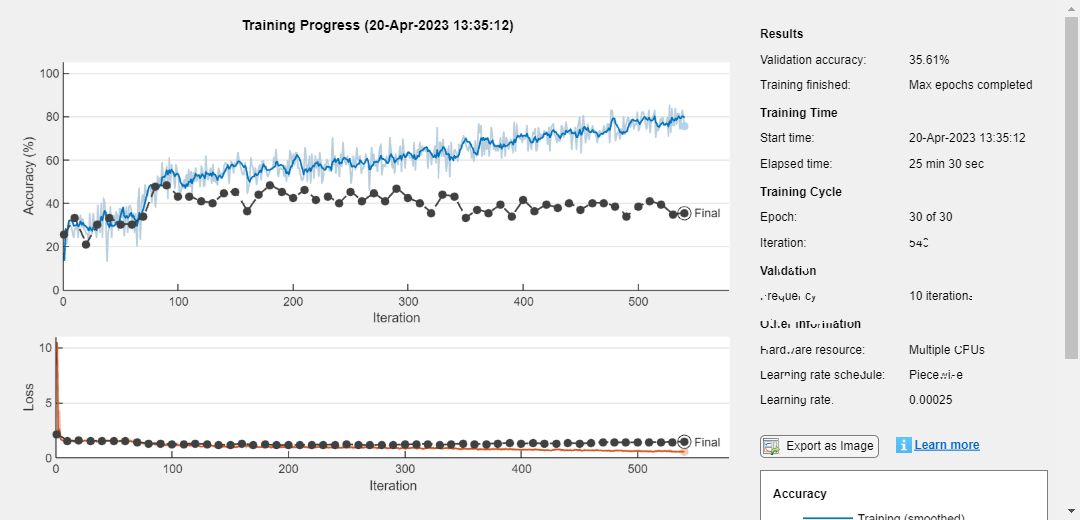
<a name="H_98D1DF18"></a>

**Save model:** Save the new trained network in a MAT format.


In [15]:
model_name = "net-class-30-1e-4-drop10-0_5"; % classification-epochs-learning_rate-drop_period-drop_factor
save(model_name+".mat","net")


Export it to a ONNXNetwork format.


In [16]:
exportONNXNetwork(net,model_name+".onnx")


**Test model:**

<a name="H_1F33C954"></a>

Plot predicted and ground truth values for steering angle using the testing dataset.


In [17]:
model_name = "net-class-30-1e-4-drop10-0_5"; % classification-epochs-learning_rate-drop_period-drop_factor
load(model_name+".mat","net")
predSteering = classify(net, testData);
figure
startTest = 80;
endTest = 100;
plot(predSteering(startTest:endTest), 'r*', "MarkerSize",10)
hold on
plot(imdsTest.Labels(startTest:endTest), 'b*')
legend("Predictions", "Actual")
hold off



Display the confusion matrix.


In [18]:
confMat = confusionmat(imdsTest.Labels, predSteering);
confusionchart(confMat)


Display the testing image and the predicted label along with the ground truth.


In [19]:
numberImages = length(imdsTest.Labels);
i = 42;
img = readimage(imdsTest, i);
imshow(img),title(char(imdsTest.Labels(i)) + "/" +char(predSteering(i)));

<a name="H_04DB5015"></a>
# Helper Functions

In [20]:
function drivinglog = import_driving_log(filename, dataLines)
%IMPORTFILE Import data from a text file
%  DRIVINGLOG = IMPORTFILE(FILENAME) reads data from text file FILENAME
%  for the default selection.  Returns the data as a table.
%
%  DRIVINGLOG = IMPORTFILE(FILE, DATALINES) reads data for the specified
%  row interval(s) of text file FILENAME. Specify DATALINES as a
%  positive scalar integer or a N-by-2 array of positive scalar integers
%  for dis-contiguous row intervals.
%
%  See also READTABLE.
%
% Auto-generated by MATLAB on 28-May-2021 21:31:34
%% Input handling
% If dataLines is not specified, define defaults
if nargin < 2
    dataLines = [1, Inf];
end
%% Set up the Import Options and import the data
opts = delimitedTextImportOptions("NumVariables", 8);
% Specify range and delimiter
opts.DataLines = dataLines;
opts.Delimiter = ",";
% Specify column names and types
opts.VariableNames = ["VarName1", "center", "left", "right", "steering", "throttle", "reverse", "speed"];
opts.VariableTypes = ["double", "string", "string", "string", "double", "double", "double", "double"];
% Specify file level properties
opts.ExtraColumnsRule = "ignore";
opts.EmptyLineRule = "read";
% Specify variable properties
opts = setvaropts(opts, ["center", "left", "right"], "WhitespaceRule", "preserve");
opts = setvaropts(opts, ["center", "left", "right"], "EmptyFieldRule", "auto");
opts = setvaropts(opts, ["VarName1", "steering", "throttle", "reverse", "speed"], "ThousandsSeparator", ",");
% Import the data
drivinglog = readtable(filename, opts);
end

In [21]:
function [dataOut, info] = imagePreprocess(dataIn, info)
imgOut = dataIn(60:135, :, :);
imgOut = rgb2ycbcr(imgOut);
imgOut = imresize(imgOut, [66 200]);
dataOut = {imgOut, info.Label};
end